In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import time

from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import v2
from torchinfo import summary
from tqdm.auto import tqdm
import cv2 as cv

/home/nata-brain/miniconda3/envs/mpt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
DATA_DIR = '/home/nata-brain/Documents/proj/image-enhancer/datasets/cable_dataset_tester/images/dae_dataset/val/'
MODEL_OUT = '../models'
NET_NAME = 'cable_novelty_v2.pt'
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SHAPE = (300, 600, 1)
LATENT_DIM = 2
BATCH_SIZE = 4

class DAE(nn.Module):
    def __init__(self, img_shape: tuple, latent_dim: int) -> None:
        super(DAE, self).__init__()
        self.img_shape = img_shape
        
        self.linear1 = nn.Linear(np.prod(img_shape), 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.latent1 = nn.Linear(512, latent_dim)
        
        self.latent2 = nn.Linear(latent_dim, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 128)
        self.linear6 = nn.Linear(128, np.prod(img_shape))
        
        self.relu = nn.LeakyReLU(negative_slope=.1, inplace=True)
        self.tanh = nn.Tanh()
    
    def encode(self, x):
        h1 = self.relu(self.linear1(x))
        h2 = self.relu(self.linear2(h1))
        return self.relu(self.linear3(h2))
    
    def decoder(self, z):
        h4 = self.relu(self.linear4(z))
        h5 = self.relu(self.linear5(h4))
        return self.tanh(self.linear6(h5))
        
    def forward(self, img):
        og_shape = img.shape
        img_flat = img.view(img.shape[0], -1)
        z = self.encode(img_flat)
        recon = self.decoder(z)
        return recon.view(og_shape)
    
model: nn.Module = DAE(IMG_SHAPE, LATENT_DIM).to(DEVICE)
model.load_state_dict(torch.load(os.path.join(MODEL_OUT, NET_NAME), 
                                 weights_only=True))
model.eval()

DAE(
  (linear1): Linear(in_features=180000, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=512, bias=True)
  (latent1): Linear(in_features=512, out_features=2, bias=True)
  (latent2): Linear(in_features=2, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=128, bias=True)
  (linear6): Linear(in_features=128, out_features=180000, bias=True)
  (relu): LeakyReLU(negative_slope=0.1, inplace=True)
  (tanh): Tanh()
)

In [6]:
def image_to_inference():
    img_transforms = v2.Compose([
        v2.Resize(IMG_SHAPE[:-1]),
        v2.Grayscale(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ])

    img = cv.imread("/home/nata-brain/Documents/proj/image-enhancer/datasets/cable_dataset_tester/images/dae_dataset/val/test/bad/0_0.67310856178716.jpg")
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = img[..., None]  # Agora a imagem terá a forma (H, W, 1)
    img = torch.from_numpy(img).permute(2, 0, 1)
    inp = img_transforms(img).unsqueeze(0)
    
    return inp


In [7]:
data_image = image_to_inference()

0.6692578792572021


<Figure size 1600x1200 with 0 Axes>

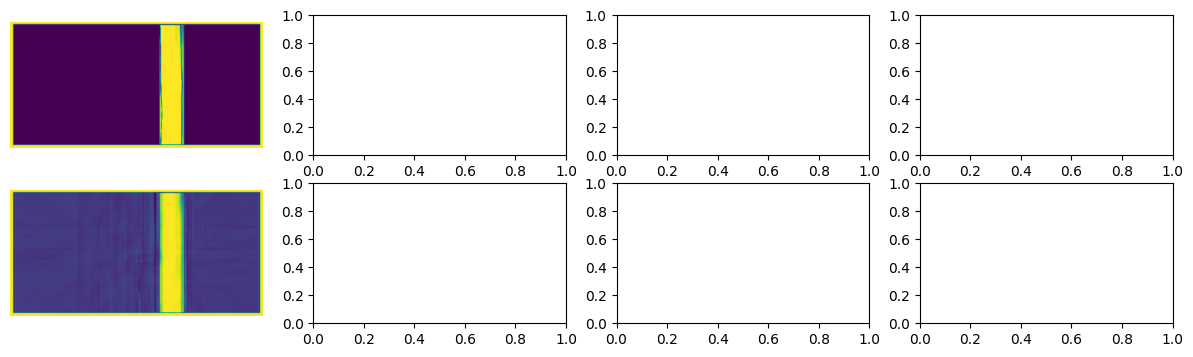

In [8]:
import matplotlib.pyplot as plt

start = time.time()

with torch.no_grad():
    data = data_image.to(DEVICE)
    recon = model(data)
    
print(time.time() - start)

plt.figure(dpi=250)

fig, ax = plt.subplots(2, 4, figsize=(15, 4))

for i in range(1):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    
plt.show()

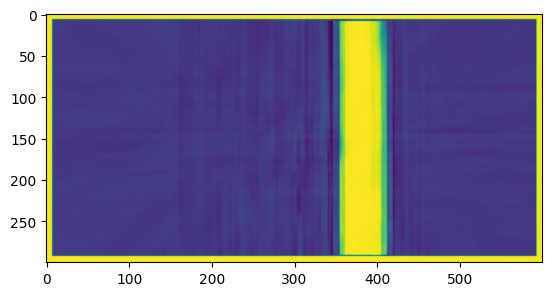

In [9]:
plt.imshow(recon[0].cpu().numpy().transpose(1,2,0))

In [10]:
def pearson_correlation(p1, p2):
    """Pearson correlation method

    Args:
        p1 (np.array): original image
        p2 (np.array): generated image

    Returns:
        float: pearson correlation between images
    """
    return np.corrcoef(p1.flatten(), p2.flatten(), rowvar=False)[0][1]

corr = list(map(pearson_correlation, data.cpu().numpy(), recon.cpu().numpy()))

print(f'Pearson Correlation Coefficients:\n\
    Min: {np.min(corr)}\n\
    Median: {np.median(corr)}\n\
    Max: {np.max(corr)}')

Pearson Correlation Coefficients:
    Min: 0.993018836308907
    Median: 0.993018836308907
    Max: 0.993018836308907


In [11]:
def stats(arr):
    """Calculates the IQR of array elements.

    Args:
        arr (np.array): array with numeric values

    Returns:
        float: IQR calculated from quartiles
        float: lower bound for anomaly detection
        float: higher bound for anomaly detection
    """
    q75, q25 = np.percentile(arr, [75, 25])
    iqr = q75 - q25
    return iqr, q25 - 1.5 * iqr, q75 + 1.5 * iqr

iqr, lower_bound, higher_bound = stats(list(map(pearson_correlation, 
                                                data.cpu().numpy(), 
                                                recon.cpu().numpy())))

print(f'IQR: {iqr}\nLower Bound: {lower_bound}\nHigher Bound: {higher_bound}')

IQR: 0.0
Lower Bound: 0.993018836308907
Higher Bound: 0.993018836308907


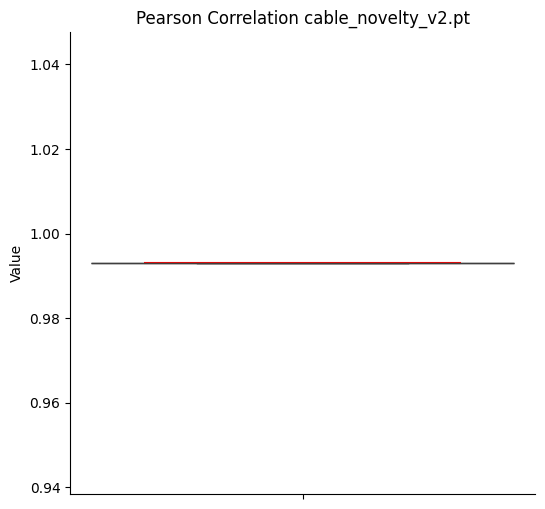

In [12]:
fig, ax = plt.subplots(figsize=(6,6))
bxp = sns.boxplot(corr)
bxp.set(ylabel='Value', title=f'Pearson Correlation {NET_NAME}')
ax.hlines(lower_bound, -.3, .3, colors='red')
# plt.ylim(.99, 1.01)
sns.despine()

/tmp/ipykernel_53929/588617013.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(distribution)
/home/nata-brain/miniconda3/envs/mpt/lib/python3.9/site-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


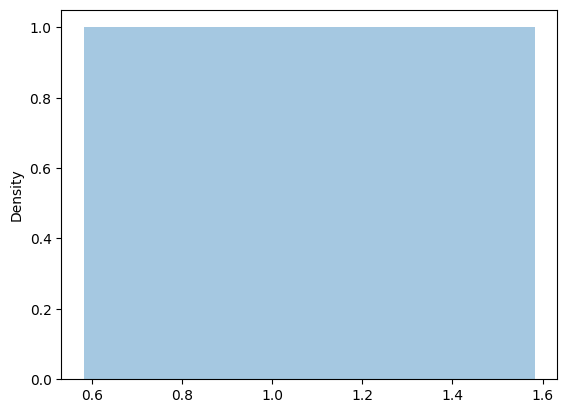

In [10]:
distribution = np.random.normal(corr)

sns.distplot(distribution)
plt.show()

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import time

from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import v2
from torchinfo import summary
from tqdm.auto import tqdm
import cv2 as cv

class DAE(nn.Module):
    def __init__(self, img_shape: tuple, latent_dim: int) -> None:
        super(DAE, self).__init__()
        self.img_shape = img_shape
        
        self.linear1 = nn.Linear(np.prod(img_shape), 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.latent1 = nn.Linear(512, latent_dim)
        
        self.latent2 = nn.Linear(latent_dim, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 128)
        self.linear6 = nn.Linear(128, np.prod(img_shape))
        
        self.relu = nn.LeakyReLU(negative_slope=.1, inplace=True)
        self.tanh = nn.Tanh()
    
    def encode(self, x):
        h1 = self.relu(self.linear1(x))
        h2 = self.relu(self.linear2(h1))
        return self.relu(self.linear3(h2))
    
    def decoder(self, z):
        h4 = self.relu(self.linear4(z))
        h5 = self.relu(self.linear5(h4))
        return self.tanh(self.linear6(h5))
        
    def forward(self, img):
        og_shape = img.shape
        img_flat = img.view(img.shape[0], -1)
        z = self.encode(img_flat)
        recon = self.decoder(z)
        return recon.view(og_shape)


def pearson_correlation(p1, p2):
    """Pearson correlation method

    Args:
        p1 (np.array): original image
        p2 (np.array): generated image

    Returns:
        float: pearson correlation between images
    """
    return np.corrcoef(p1.flatten(), p2.flatten(), rowvar=False)[0][1]


def stats(arr):
    """Calculates the IQR of array elements.

    Args:
        arr (np.array): array with numeric values

    Returns:
        float: IQR calculated from quartiles
        float: lower bound for anomaly detection
        float: higher bound for anomaly detection
    """
    q75, q25 = np.percentile(arr, [75, 25])
    iqr = q75 - q25
    return iqr, q25 - 1.5 * iqr, q75 + 1.5 * iqr


def novelty_inference(model, data_dir, batch_size, device, img_shape, threshold = 0.963608371833327):
    """Method novelty model inference

    Args:
        model (pytorch model): novelty detection model
        data_dir (str): data path
        batch_size (int): qtd images to process
        device (str): describre the device to process
        img_shape (tuple): image shape
        threshold (float, optional): novelty threshold. Defaults to 0.963608371833327.
    """
    
    out_dir = f"./negative_results"
    os.makedirs(out_dir, exist_ok = True)

    img_transforms = v2.Compose([
        v2.Resize(img_shape[:-1]),
        v2.Grayscale(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ])

    val_set = datasets.ImageFolder(
        os.path.join(data_dir, 'test'),
        transform=img_transforms)

    val_loader = DataLoader(val_set, batch_size, shuffle=False)

    with torch.no_grad():
        for data, _ in val_loader:
            data = data.to(device)
            recon = model(data)
            break
 
    corr = list(map(pearson_correlation, data.cpu().numpy(), recon.cpu().numpy()))
    print(corr)
    for i, c in enumerate(corr):
        original_image = data[i].cpu().numpy().transpose((1, 2, 0))

        if c < threshold:
            
           fig, ax = plt.subplots(1, 1, figsize=(10, 7))
           ax.imshow(original_image, cmap = plt.cm.gray)
           ax.axis('OFF')
           fig.savefig(f"{out_dir}/{i}_{c}.jpg", bbox_inches="tight")
           plt.close()
     
            
def pipeline():
    DATA_DIR = '/home/nata-brain/Documents/proj/image-enhancer/datasets/cable_dataset_tester/images/dae_dataset/val/'
    MODEL_OUT = '../models'
    NET_NAME = 'cable_novelty_v2.pt'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    IMG_SHAPE = (300, 600, 1)
    LATENT_DIM = 2
    BATCH_SIZE = 4
    
    model: nn.Module = DAE(IMG_SHAPE, LATENT_DIM).to(DEVICE)
    model.load_state_dict(torch.load(os.path.join(MODEL_OUT, NET_NAME), 
                                    weights_only=True))
    
    novelty_inference(model = model, data_dir = DATA_DIR, batch_size = BATCH_SIZE, 
                      device = DEVICE, img_shape = IMG_SHAPE, threshold = 0.9)

In [16]:
pipeline()

[0.9930188670599874, 0.7491710717288778, -0.04740633526505028, -0.03213669994781602]
